In [1]:
from google.colab import drive
drive.mount('/content/drive')
url = '/content/drive/My Drive/Dataset/domain1/'

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


Successfully loaded image 1: /content/drive/My Drive/Dataset/domain1/trajectory34_RSP134.png


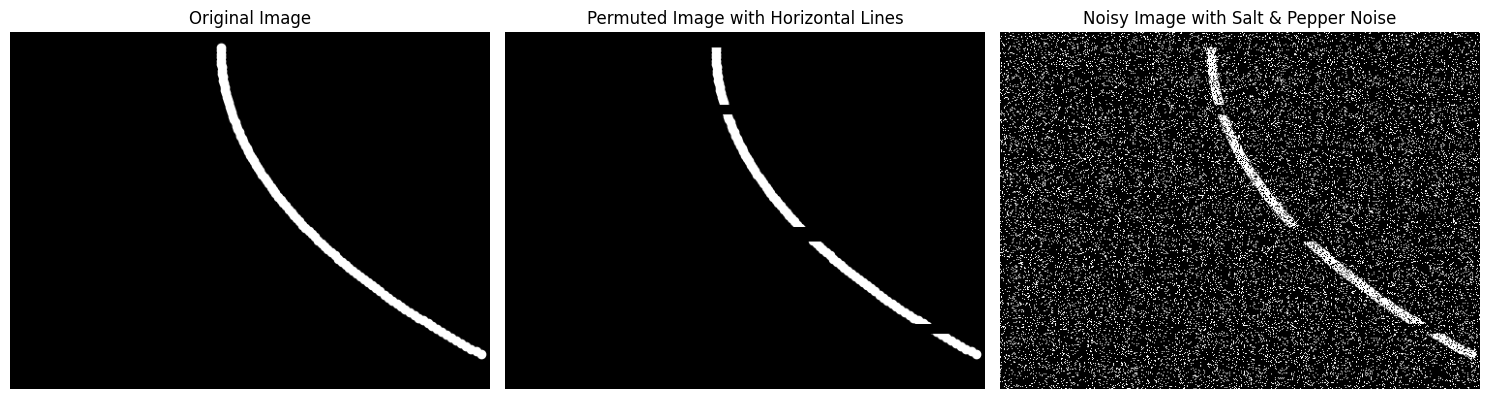

In [3]:
class NoisyImage(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        self.transform = transform
        self.loaded_images = 0

    def __len__(self):
        return len(self.image_names)

    def add_horizontal_lines(self, image):

        line_thickness = 10  # Thickness of lines
        num_lines =5  #Number of Horizontal lines

        # Randomly select positions for horizontal lines
        line_positions = np.random.randint(0, image.shape[0], num_lines)

        for pos in line_positions:
            image[pos:pos + line_thickness, :] = 0

        return image

    def add_salt_pepper_noise(self, image):
        amount = 0.4
        s_vs_p = 0.4
        noisy = np.copy(image)

        # Salt mode (white pixels)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords_salt = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
        noisy[tuple(coords_salt)] = 255

        # Pepper mode (black pixels)
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords_pepper = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
        noisy[tuple(coords_pepper)] = 0

        return noisy

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_names[idx])
        image = cv2.imread(image_path, 0)  # Read as single channel image
        if image is None:
            print(f"Failed to load image at {image_path}")
            return None, None, None  # Return None for all images if loading failed
        self.loaded_images += 1
        print(f"Successfully loaded image {self.loaded_images}: {image_path}")

        # Apply horizontal black lines first
        image_with_lines = self.add_horizontal_lines(np.copy(image))

        # Add salt and pepper noise
        noisy_image = self.add_salt_pepper_noise(np.copy(image_with_lines))

        # Convert to PIL images for visualization
        original_pil = Image.fromarray(image)
        permuted_pil = Image.fromarray(image_with_lines)
        noisy_pil = Image.fromarray(noisy_image)

        # Apply transformations if specified
        if self.transform:
            original_pil = self.transform(original_pil)
            permuted_pil = self.transform(permuted_pil)
            noisy_pil = self.transform(noisy_pil)

        return original_pil, permuted_pil, noisy_pil

# Test with a single image

image_path = url+'Copy of trajectory34_RSP167.png'
dataset = NoisyImage(folder_path=os.path.dirname(image_path))
original_image, permuted_image, noisy_image = dataset[0]

# Display the images side by side
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Permuted Image with Horizontal Lines
plt.subplot(1, 3, 2)
plt.imshow(permuted_image, cmap='gray')
plt.title("Permuted Image with Horizontal Lines")
plt.axis('off')

# Noisy Image with Salt & Pepper Noise
plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image with Salt & Pepper Noise")
plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
#  transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = NoisyImage(url, transform=transform)

# Filter out None values and count loaded images
filtered_dataset = [(noisy_img, img, idx) for noisy_img, img, idx in dataset if noisy_img is not None and img is not None]
print(f"Total loaded images: {dataset.loaded_images}")

# Split dataset into train and test
train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Streaming output truncated to the last 5000 lines.
Successfully loaded image 3228: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP170.png
Successfully loaded image 3229: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP172.png
Successfully loaded image 3230: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP178.png
Successfully loaded image 3231: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP174.png
Successfully loaded image 3232: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP173.png
Successfully loaded image 3233: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP183.png
Successfully loaded image 3234: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP168.png
Successfully loaded image 3235: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP194.png
Successfully loaded image 3236: /content/drive/My Drive/Dataset/domain1/trajectory23_RSP18.png
Successfully loaded image 3237: /content/drive/My Drive/Dataset/domain1/trajectory23_R

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [6]:

G = Generator().to(device)
F = Generator().to(device)
D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)

# Losses and optimizers
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_F = optim.Adam(F.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for i, (original_images, permuted_images, noisy_images) in enumerate(train_loader):
        original_images, noisy_images = original_images.to(device), noisy_images.to(device)

        # Real and fake labels with the shape matching discriminator output
        valid = torch.ones(noisy_images.size(0), 1, 1, 1).to(device)
        fake = torch.zeros(noisy_images.size(0), 1, 1, 1).to(device)

        # Train Generators
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()

        # Identity loss
        idt_Y = G(original_images)
        loss_idt_Y = criterion_identity(idt_Y, original_images) * 5.0
        idt_X = F(noisy_images)
        loss_idt_X = criterion_identity(idt_X, noisy_images) * 5.0

        # GAN loss
        fake_Y = G(noisy_images)
        fake_X = F(original_images)
        loss_GAN_G = criterion_GAN(D_Y(fake_Y), valid.expand_as(D_Y(fake_Y)))
        loss_GAN_F = criterion_GAN(D_X(fake_X), valid.expand_as(D_X(fake_X)))

        # Cycle loss
        recov_X = F(fake_Y)
        recov_Y = G(fake_X)
        loss_cycle_X = criterion_cycle(recov_X, noisy_images) * 10.0
        loss_cycle_Y = criterion_cycle(recov_Y, original_images) * 10.0

        # Total loss
        loss_G = loss_GAN_G + loss_GAN_F + loss_cycle_X + loss_cycle_Y + loss_idt_X + loss_idt_Y

        loss_G.backward()
        optimizer_G.step()
        optimizer_F.step()

        # Train Discriminator D_X
        optimizer_D_X.zero_grad()
        loss_real_X = criterion_GAN(D_X(noisy_images), valid.expand_as(D_X(noisy_images)))
        loss_fake_X = criterion_GAN(D_X(fake_X.detach()), fake.expand_as(D_X(fake_X.detach())))
        loss_D_X = (loss_real_X + loss_fake_X) / 2
        loss_D_X.backward()
        optimizer_D_X.step()

        # Train Discriminator D_Y
        optimizer_D_Y.zero_grad()
        loss_real_Y = criterion_GAN(D_Y(original_images), valid.expand_as(D_Y(original_images)))
        loss_fake_Y = criterion_GAN(D_Y(fake_Y.detach()), fake.expand_as(D_Y(fake_Y.detach())))
        loss_D_Y = (loss_real_Y + loss_fake_Y) / 2
        loss_D_Y.backward()
        optimizer_D_Y.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(train_loader)} '
              f'Loss D_X: {loss_D_X.item():.4f}, Loss D_Y: {loss_D_Y.item():.4f}, '
              f'Loss G: {loss_G.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Streaming output truncated to the last 5000 lines.
Epoch [2/50] Batch 48/103 Loss D_X: 0.2489, Loss D_Y: 0.2406, Loss G: 1.4763
Epoch [2/50] Batch 49/103 Loss D_X: 0.2647, Loss D_Y: 0.2424, Loss G: 1.4756
Epoch [2/50] Batch 50/103 Loss D_X: 0.2563, Loss D_Y: 0.2410, Loss G: 1.4575
Epoch [2/50] Batch 51/103 Loss D_X: 0.2607, Loss D_Y: 0.2418, Loss G: 1.4454
Epoch [2/50] Batch 52/103 Loss D_X: 0.2679, Loss D_Y: 0.2384, Loss G: 1.4964
Epoch [2/50] Batch 53/103 Loss D_X: 0.2533, Loss D_Y: 0.2453, Loss G: 1.5104
Epoch [2/50] Batch 54/103 Loss D_X: 0.2535, Loss D_Y: 0.2394, Loss G: 1.5053
Epoch [2/50] Batch 55/103 Loss D_X: 0.2495, Loss D_Y: 0.2436, Loss G: 1.4482
Epoch [2/50] Batch 56/103 Loss D_X: 0.2394, Loss D_Y: 0.2387, Loss G: 1.4586
Epoch [2/50] Batch 57/103 Loss D_X: 0.2468, Loss D_Y: 0.2461, Loss G: 1.4983
Epoch [2/50] Batch 58/103 Loss D_X: 0.2322, Loss D_Y: 0.2374, Loss G: 1.5350
Epoch [2/50] Batch 59/103 Loss D_X: 0.2495, Loss D_Y: 0.2449, Loss G: 1.4889
Epoch [2/50] Batch 60/103

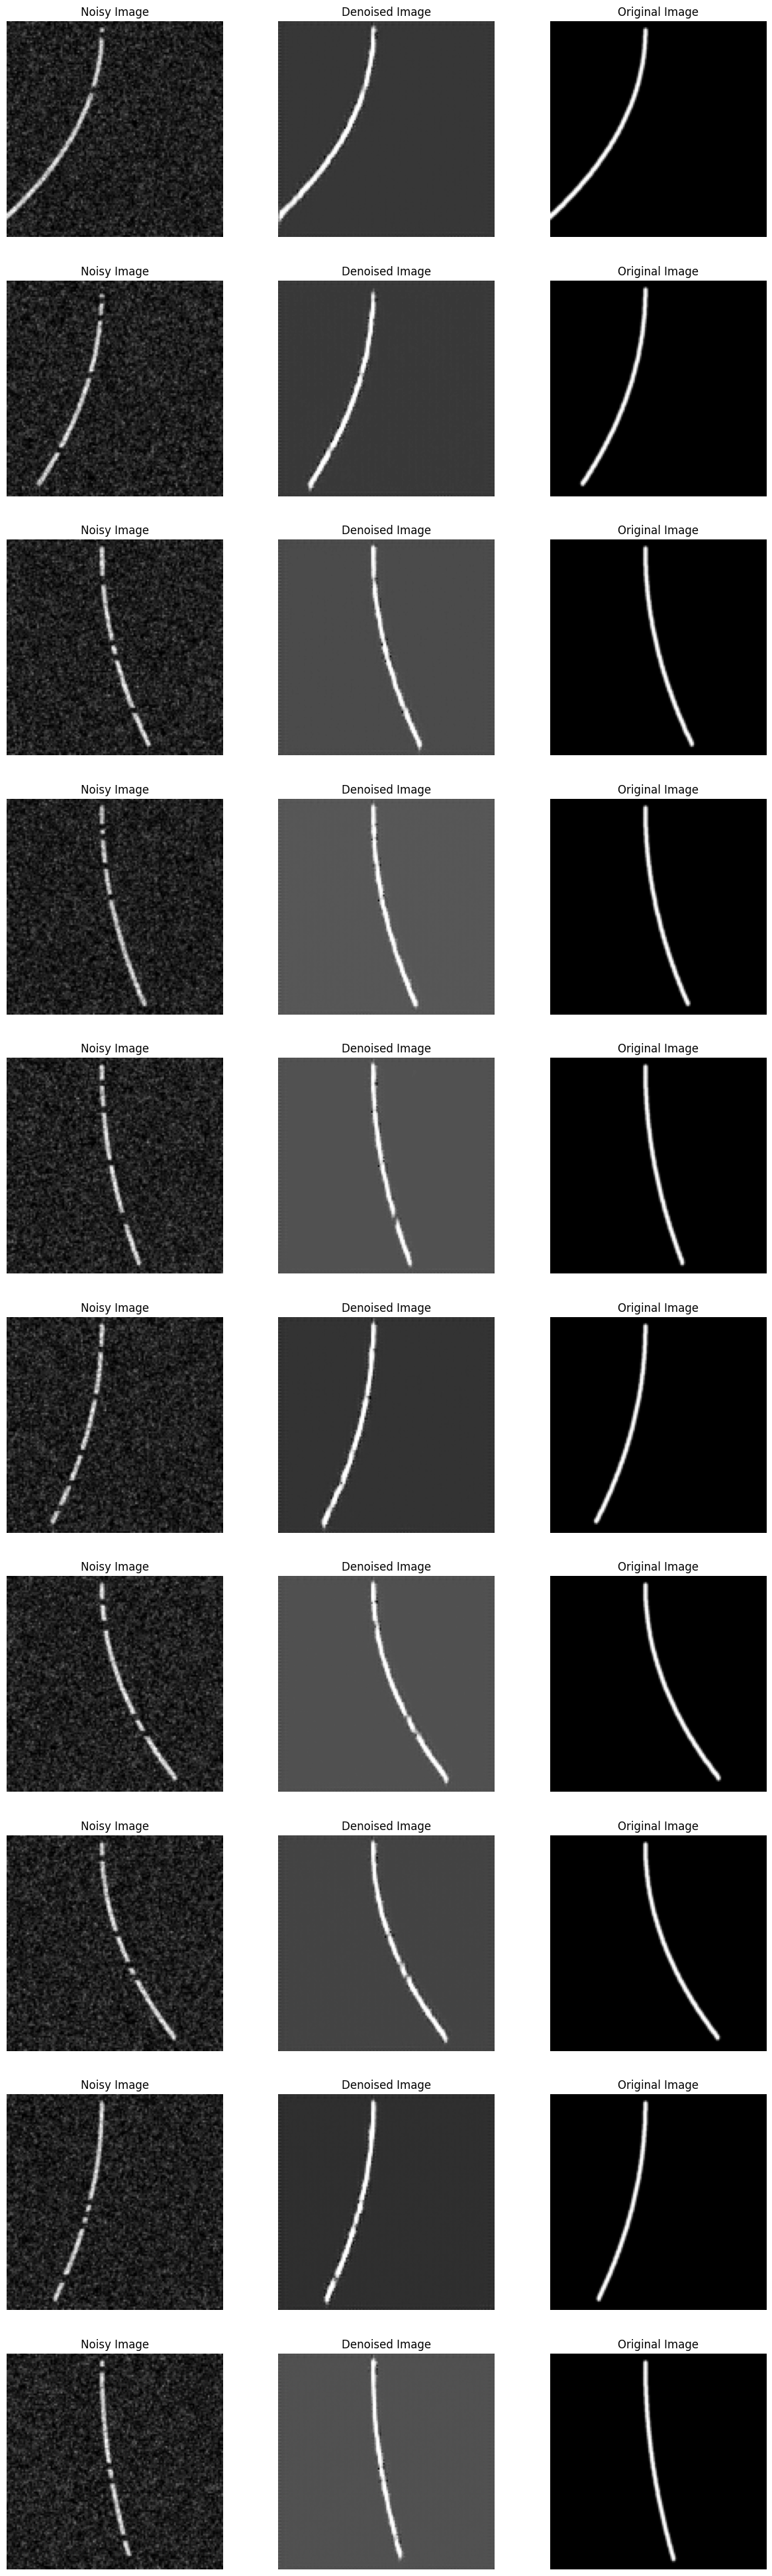

In [7]:


#G and F are in evaluation mode
G.eval()
F.eval()

test_img_num = 10  # Number of images to display
with torch.no_grad():
    # Select 10 images from the test set
    indices = random.sample(range(len(test_dataset)), test_img_num)
    selected_images = [test_dataset[i] for i in indices]

    # Process selected images
    noisy_images = torch.stack([img[2] for img in selected_images]).to(device)  # Using the noisy images
    original_images = torch.stack([img[0] for img in selected_images]).to(device)  # Using the original images
    denoised_images = G(noisy_images)  # Generate denoised images using the generator G

    # Plot the images
    fig, axs = plt.subplots(test_img_num, 3, figsize=(15, 50))
    for i in range(test_img_num):
        axs[i, 0].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axs[i, 0].set_title('Noisy Image')
        axs[i, 1].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
        axs[i, 1].set_title('Denoised Image')
        axs[i, 2].imshow(original_images[i].cpu().squeeze(), cmap='gray')
        axs[i, 2].set_title('Original Image')
        for ax in axs[i, :]:
            ax.axis('off')
    plt.show()
